In [1]:
import os
from pathlib import Path

import hydra
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
from types import SimpleNamespace

from diffusion_reward.models.video_models.vqdiffusion.modeling.build import build_model
from diffusion_reward.models.video_models.vqdiffusion.modeling.transformers.diffusion_transformer import (
    index_to_log_onehot, log_categorical, log_onehot_to_index,
    sum_except_batch)
from diffusion_reward.models.video_models.vqdiffusion.utils.io import load_yaml_config
from diffusion_reward.models.video_models.vqdiffusion.utils.misc import get_model_parameters_info

import numpy as np
import pickle

/home/dongyoon/anaconda3/envs/diffusion_reward/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
class Custom_DiffusionReward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.info = self.get_model(ema=True, model_path=cfg.ckpt_path, config_path=cfg.cfg_path)
        self.model = self.info['model']
        self.epoch = self.info['epoch']
        self.model_name = self.info['model_name']
        self.model.eval()
        
        for param in self.model.parameters(): 
            param.requires_grad = False
        
        # set attribute
        for attr_name, attr_value in vars(cfg).items():
            setattr(self, attr_name, attr_value)
        
    def get_model(self, ema, model_path, config_path):
        if 'OUTPUT' in model_path: # pretrained model
            model_name = model_path.split(os.path.sep)[-3] # model_name으로 끝나는 경로
        else: 
            model_name = os.path.basename(config_path).replace('.yaml', '')
            
        config = load_yaml_config(config_path)

        model = build_model(config)
        model_parameters = get_model_parameters_info(model)
        
        print(model_parameters)
        if os.path.exists(model_path):
            ckpt = torch.load(model_path, map_location="cpu")
            if 'last_epoch' in ckpt:
                epoch = ckpt['last_epoch']
            elif 'epoch' in ckpt:
                epoch = ckpt['epoch']
            else:
                epoch = 0

            missing, unexpected = model.load_state_dict(ckpt["model"], strict=False)
            print('Model missing keys:\n', missing)
            print('Model unexpected keys:\n', unexpected)

            if ema==True and 'ema' in ckpt:
                print("Evaluate EMA model")
                ema_model = model.get_ema_model()
                missing, unexpected = ema_model.load_state_dict(ckpt['ema'], strict=False)
        else:
            epoch = None
        return {'model': model, 'epoch': epoch, 'model_name': model_name, 'parameter': model_parameters}
    
    def imgs_to_batch(self, x, reward_type='entropy'):
        '''
        input:
            imgs: B * T * H * W * C
            (mostly): 1 * T * ...
        '''
        assert x.max() <= 1
        # preprocessing
        seq_len = x.shape[1]
        num_frames = self.model.cfg.params['condition_emb_config']['params']['num_cond_frames']
        n_skip = self.model.frame_skip
        subseq_len = (num_frames + 1) * n_skip

        x = x.permute(0, 1, 4, 2 ,3) # B * T * H * W * C -> B * T * C * H * W
        _, indices = self.model.content_codec.encode_to_z(x)
        assert indices.shape[0] == 1
        indices = indices.reshape(indices.shape[0], seq_len, -1)

        if reward_type == 'entropy':
            # only return conditional frames
            post_idxes = list(range(seq_len - subseq_len + 2))
            batch_indices = [indices[:, idx:idx+subseq_len-n_skip:n_skip] for idx in post_idxes]
            batch_indices = torch.stack(batch_indices, dim=0)
            batch_indices = batch_indices.squeeze(1).reshape(batch_indices.shape[0], -1)    
            
            if subseq_len - 2 > 0:
                pre_batch_indices = [indices[:, idx].tile((1, num_frames)) for idx in range(subseq_len-2)]
                pre_batch_indices = torch.concat(pre_batch_indices, dim=0)
                batch_indices = torch.concat([pre_batch_indices, batch_indices], dim=0)
            cond = {'condition_token': batch_indices}
        elif reward_type == 'likelihood':
            # return conditional frames + current frame
            post_idxes = list(range(seq_len - subseq_len + 1))
            batch_indices = [indices[:, idx:idx+subseq_len-n_skip:n_skip] for idx in post_idxes]
            batch_indices = torch.stack(batch_indices, dim=0)
            batch_indices = batch_indices.squeeze(1).reshape(batch_indices.shape[0], -1)    
            
            if subseq_len - 2 > 0:
                pre_batch_indices = [indices[:, idx].tile((1, num_frames)) for idx in range(subseq_len-1)]
                pre_batch_indices = torch.concat(pre_batch_indices, dim=0)
                batch_indices = torch.concat([pre_batch_indices, batch_indices], dim=0)
            cond = {'condition_token': batch_indices}
        else:
            raise NotImplementedError

        x = x.flatten(0, 1)
        cont = {'content_token': indices[0]}
        return cont, cond, indices[0]
    
    @torch.no_grad()
    def calc_reward(self, imgs):
        self.model.eval()
        content, condition, _ = self.imgs_to_batch(imgs, reward_type=self.reward_type)
        content_token = content['content_token']
        condition_token = condition['condition_token']

        rewards = self.calc_vlb(content_token, condition_token)
        if self.use_std:
            rewards_std = (rewards - self.stat[0]) / self.stat[1]
            scaled_rewards = (1 - self.expl_scale) * rewards_std
            return scaled_rewards  
        else:
            return rewards
    
    @torch.no_grad()
    def calc_vlb(self, cont_emb, cond_emb):
        x = cont_emb
        b, device = x.size(0), x.device
        transformer = self.model.transformer
        cond_emb = transformer.condition_emb(cond_emb).float()

        # t=0
        start_step = transformer.num_timesteps
        x_start = x
        t = torch.full((b,), start_step-1, device=device, dtype=torch.long)
        log_x_start = index_to_log_onehot(x_start, transformer.num_classes)

        # t=T
        zero_logits = torch.zeros((b, transformer.num_classes-1, transformer.shape),device=device)
        one_logits = torch.ones((b, 1, transformer.shape),device=device)
        mask_logits = torch.cat((zero_logits, one_logits), dim=1)
        log_z = torch.log(mask_logits)

        # denoised time_steps
        diffusion_list = [index for index in range(start_step-1, -1, -1-self.skip_step)]
        if diffusion_list[-1] != 0:
            diffusion_list.append(0)

        vlbs = []
        if self.reward_type == 'entropy':
            # use denoised samples for estimation
            for _ in range(self.num_sample):
                start_step = transformer.num_timesteps
                x_start = x
                t = torch.full((b,), start_step-1, device=device, dtype=torch.long)
                log_x_start = index_to_log_onehot(x_start, transformer.num_classes)

                # t=T
                zero_logits = torch.zeros((b, transformer.num_classes-1, transformer.shape),device=device)
                one_logits = torch.ones((b, 1, transformer.shape),device=device)
                mask_logits = torch.cat((zero_logits, one_logits), dim=1)
                log_z = torch.log(mask_logits)

                model_log_probs = []
                log_zs = []
                ts = []
                vlb = []
                for diffusion_index in diffusion_list:
                    t = torch.full((b,), diffusion_index, device=device, dtype=torch.long)
                    log_x_recon = transformer.cf_predict_start(log_z, cond_emb, t)
                    log_zs.append(log_z)
                    if diffusion_index > self.skip_step:
                        model_log_prob = transformer.q_posterior(log_x_start=log_x_recon, log_x_t=log_z, t=t-self.skip_step)
                        ts.append(t-self.skip_step)
                    else:
                        model_log_prob = transformer.q_posterior(log_x_start=log_x_recon, log_x_t=log_z, t=t)
                        ts.append(t)

                    model_log_probs.append(model_log_prob)
                    log_z = transformer.log_sample_categorical(model_log_prob, noise=self.noise, noise_scale=self.noise_scale)

                x_start = log_onehot_to_index(log_z)
                log_x_start = index_to_log_onehot(x_start, transformer.num_classes)
                for i, model_log_prob in enumerate(model_log_probs[:-1]):
                    log_true_prob = transformer.q_posterior(log_x_start=log_x_start, log_x_t=log_zs[i], t=ts[i])
                    kl = transformer.multinomial_kl(log_true_prob, model_log_prob)
                    kl = sum_except_batch(kl).unsqueeze(1)
                    vlb.append(-kl)

                log_probs = model_log_probs[-1].permute(0, 2, 1)
                target = F.one_hot(x_start, num_classes=transformer.num_classes)
                rewards = (log_probs * target).sum(-1).sum(-1)
                rewards += torch.concat(vlb, dim=1).sum(dim=1)
                vlbs.append(rewards)
        elif self.reward_type == 'likelihood':
            # use observed samples for estimation
            for diffusion_index in diffusion_list:
                t = torch.full((b,), diffusion_index, device=device, dtype=torch.long)
                log_x_recon = transformer.cf_predict_start(log_z, cond_emb, t)
                if diffusion_index > self.skip_step:
                    model_log_prob = transformer.q_posterior(log_x_start=log_x_recon, log_x_t=log_z, t=t-self.skip_step)
                    log_true_prob = transformer.q_posterior(log_x_start=log_x_start, log_x_t=log_z, t=t-self.skip_step)
                else:
                    model_log_prob = transformer.q_posterior(log_x_start=log_x_recon, log_x_t=log_z, t=t)
                    log_true_prob = transformer.q_posterior(log_x_start=log_x_start, log_x_t=log_z, t=t)

                log_z = transformer.log_sample_categorical(model_log_prob, noise=self.noise, noise_scale=self.noise_scale)

                # -KL if t !=0 else LL
                if diffusion_index != 0:
                    kl = transformer.multinomial_kl(log_true_prob, model_log_prob)
                    kl = sum_except_batch(kl).unsqueeze(1)
                    vlbs.append(-kl)
                else:
                    decoder_ll = log_categorical(log_x_start, model_log_prob)
                    decoder_ll = sum_except_batch(decoder_ll).unsqueeze(1)   
                    vlbs.append(decoder_ll)

        else:
            raise NotImplementedError

        rewards = torch.stack(vlbs, dim=1).mean(1)
        return rewards

In [34]:
import yaml
from types import SimpleNamespace

with open('/home/dongyoon/diffusion_reward/custom_config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    config = SimpleNamespace(**config)
reward_model = Custom_DiffusionReward(config)
if torch.cuda.is_available():
    reward_model = reward_model.to('cuda:6')

{'overall': {'trainable': '36.71M', 'non_trainable': '0', 'total': '36.71M'}, 'content_codec': {'trainable': '19.53M', 'non_trainable': '0', 'total': '19.53M'}, 'transformer': {'trainable': '17.18M', 'non_trainable': '0', 'total': '17.18M'}}
Model missing keys:
 []
Model unexpected keys:
 []
Evaluate EMA model


In [4]:
import yaml
file_path = '/home/dongyoon/FB_dataset/raw/low/one_leg/train/2023-12-07-20:45:49.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

def pickle_to_frames(data):
    frames = []
    for i in range(len(data['observations'])):
        frames.append(data['observations'][i]['color_image2'])
    frames = np.array(frames)
    print(frames.shape)
    frames = frames.transpose(0, 2, 3, 1) #(T, C, H, W) -> (T, H, W, C)
    return frames

frames = pickle_to_frames(data)

(489, 3, 224, 224)


In [39]:
file_path = '/home/dongyoon/FB_dataset/raw/low/one_leg/train/2023-12-07-20:45:49.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

def pickle_to_frames(data):
    frames = []
    for i in range(len(data['observations'])):
        frames.append(data['observations'][i]['color_image2'])
    frames = np.array(frames)
    frames = frames.transpose(0, 2, 3, 1) #(T, C, H, W) -> (T, H, W, C)
    return frames

frames = pickle_to_frames(data)
frames = frames[:50]

frames = np.expand_dims(frames, axis=0)
frames = frames.astype(np.float32)
frames = frames / 127.5 - 1
frames = torch.from_numpy(frames).float().to('cuda')

reward = reward_model.calc_reward(frames)
print(reward)

tensor([-393.5468, -363.7548, -383.6244, -388.3673, -370.0813, -354.4147,
        -356.7564, -378.4588, -380.0421, -379.7645, -381.4563, -372.2559,
        -389.3754, -385.4512, -364.2169, -363.7416, -355.0946, -357.0281,
        -374.3409, -354.9199, -369.6879, -357.2112, -381.2681, -402.9602,
        -375.3313, -372.0098, -352.2092, -347.6044, -377.4667, -374.1561,
        -378.0436, -384.1049, -367.0670, -371.0377, -364.3014, -377.6213,
        -379.4636, -359.9478, -384.2962, -374.1727, -387.1054, -385.3179,
        -375.9395, -371.2265, -390.5271, -375.7778, -388.3986, -372.3849,
        -362.4117, -359.3121], device='cuda:0')


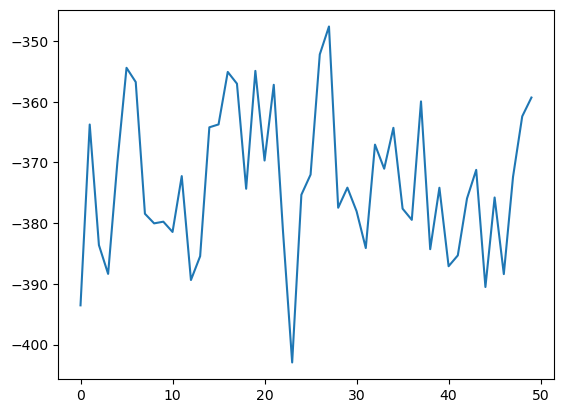

In [42]:
import matplotlib.pyplot as plt
reward_std = reward - reward.mean()
plt.plot(reward.cpu().numpy())

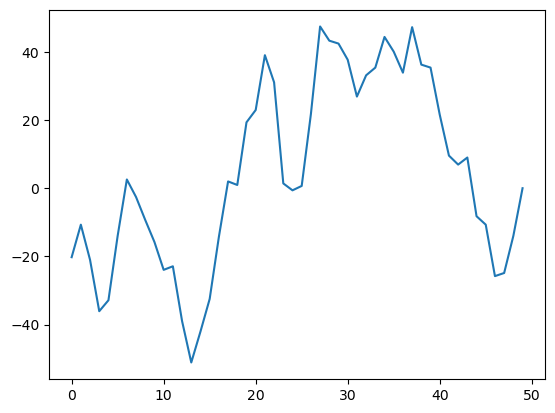

In [45]:

plt.plot(np.cumsum(reward_std.cpu().numpy()))